# Group Classification (ZenML)

Train the `GroupClassifier` on real preprocessed time-group data:
- Load preprocessed time groups from .npy files in the data folder
- Train the `GroupClassifier` via a ZenML pipeline with Optuna hyperparameter tuning
- Reload artifacts and render evaluation plots (confusion matrices, ROC curves, etc.)


In [1]:
import os
import optuna
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines.training import group_classification_optuna_pipeline
from pioneerml.optuna import OptunaStudyManager
from pioneerml.data import CLASS_NAMES, NUM_GROUP_CLASSES

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")

# Set up Optuna storage
optuna_manager = OptunaStudyManager(
    project_root=PROJECT_ROOT,
    study_name="group_classifier",
)
optuna_storage = optuna_manager.resolve_storage()
print(f"Using Optuna storage: {optuna_storage}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default
Using Optuna storage: sqlite:////home/jack/python_projects/pioneerML/.optuna/group_classifier.db


In [2]:
# Run (or reuse) the Optuna + training pipeline

file_pattern = str(Path(PROJECT_ROOT) / 'data' / 'mainTimeGroups_*.npy')

run = group_classification_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        'file_pattern': file_pattern,
        'max_files': 20,
        'limit_groups': 1000000,
        'min_hits': 2,
        'min_hits_per_label': 2,
        'batch_size': 64,
        'val_split': 0.15,
        'seed': 42,
    },
    run_hparam_search_params={
        'n_trials': 64,  # set >0 to add trials; 0 to reuse previous best if storage has it
        'max_epochs': 4,
        'limit_train_batches': 0.8,
        'limit_val_batches': 1.0,
        'storage': optuna_storage,
        'study_name': 'group_classifier',
    },
    train_best_model_params={
        'max_epochs': 16,
        'early_stopping': True,
        'early_stopping_patience': 4,
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: group_classification_optuna_pipeline.
Caching is disabled by default for group_classification_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_group_classification_datamodule has started.


[build_group_classification_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_group_classification_datamodule] Starting to load data from: /home/jack/python_projects/pioneerML/data/mainTimeGroups_*.npy
[build_group_classification_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_group_classification_datamodule] Loaded 322925 groups from 11 files (pion: 109999, muon: 109918, mip: 109988)
[build_group_classification_datamodule] Loaded 322925 groups. Building datamodule...
[build_group_classification_datamodule] Calling setup(stage='fit')...
[build_group_classification_datamodule] Setup complete. Train: 274487, Val: 48438


Step build_group_classification_datamodule has finished in 27.920s.
Step run_group_classification_hparam_search has started.


[run_group_classification_hparam_search] Using GPU: NVIDIA GeForce RTX 5070
[run_group_classification_hparam_search] CUDA devices: 1
[run_group_classification_hparam_search] Enabled Tensor Core optimization (medium precision)
[run_group_classification_hparam_search] Dataset sizes - Train: 274487, Val: 48438
[run_group_classification_hparam_search] Starting Optuna search with 64 trials, 4 epochs per trial...
[I 2025-12-05 20:43:02,939] Using an existing study with name 'group_classifier' instead of creating a new one.
[run_group_classification_hparam_search] Starting Optuna study (storage=sqlite:////home/jack/python_projects/pioneerML/.optuna/group_classifier.db, name=group_classifier)...


  0%|          | 0/64 [00:00<?, ?it/s]

[run_group_classification_hparam_search] Trial 1/64 (cumulative 8/71) starting...
[run_group_classification_hparam_search] Trial 1 params: batch_size=32, hidden=192, num_blocks=4, dropout=0.1280, lr=0.000573, weight_decay=0.000013
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 1 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 1 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 1 completed with score: 0.997785
[run_group_classification_hparam_search] Trial 2/64 (cumulative 9/71) starting...
[run_group_classification_hparam_search] Trial 2 params: batch_size=32, hidden=256, num_blocks=3, dropout=0.1224, lr=0.000323, weight_decay=0.000320
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 2 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 21:04:45,376] Trial 7 finished with value: 0.9977845549583435 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.1280092672021823, 'lr': 0.0005733593624562995, 'weight_decay': 1.263553879944107e-05}. Best is trial 7 with value: 0.9977845549583435.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 2 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 2 completed with score: 0.998851
[run_group_classification_hparam_search] Trial 3/64 (cumulative 10/71) starting...
[run_group_classification_hparam_search] Trial 3 params: batch_size=64, hidden=192, num_blocks=3, dropout=0.2388, lr=0.002082, weight_decay=0.000029
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 3 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 21:23:43,860] Trial 8 finished with value: 0.9988510608673096 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.12243721947951447, 'lr': 0.0003233140497743208, 'weight_decay': 0.0003197805629461727}. Best is trial 8 with value: 0.9988510608673096.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 3 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 3 completed with score: 0.996428
[run_group_classification_hparam_search] Trial 4/64 (cumulative 11/71) starting...
[run_group_classification_hparam_search] Trial 4 params: batch_size=128, hidden=192, num_blocks=4, dropout=0.1964, lr=0.001225, weight_decay=0.000692
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 4 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 21:33:34,766] Trial 9 finished with value: 0.9964279532432556 and parameters: {'batch_size': 64, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.2387665140600133, 'lr': 0.0020820132399251446, 'weight_decay': 2.897534110000683e-05}. Best is trial 8 with value: 0.9988510608673096.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 4 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 4 completed with score: 0.998934
[run_group_classification_hparam_search] Trial 5/64 (cumulative 12/71) starting...
[run_group_classification_hparam_search] Trial 5 params: batch_size=128, hidden=192, num_blocks=3, dropout=0.0638, lr=0.002944, weight_decay=0.000046
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 5 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 21:40:37,822] Trial 10 finished with value: 0.9989335536956787 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.1964043455875078, 'lr': 0.0012246356745766775, 'weight_decay': 0.0006920888863213135}. Best is trial 10 with value: 0.9989335536956787.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 5 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 5 completed with score: 0.998486
[run_group_classification_hparam_search] Trial 6/64 (cumulative 13/71) starting...
[run_group_classification_hparam_search] Trial 6 params: batch_size=32, hidden=256, num_blocks=3, dropout=0.1119, lr=0.001433, weight_decay=0.000241
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 6 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 21:46:27,545] Trial 11 finished with value: 0.9984862208366394 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.0637609806947653, 'lr': 0.002944361908451031, 'weight_decay': 4.591759036477442e-05}. Best is trial 10 with value: 0.9989335536956787.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 6 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 6 completed with score: 0.995438
[run_group_classification_hparam_search] Trial 7/64 (cumulative 14/71) starting...
[run_group_classification_hparam_search] Trial 7 params: batch_size=32, hidden=256, num_blocks=3, dropout=0.1984, lr=0.001560, weight_decay=0.000381
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 7 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 22:05:03,871] Trial 12 finished with value: 0.9954376220703125 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.11185388747664751, 'lr': 0.0014330242495647065, 'weight_decay': 0.00024079760667576069}. Best is trial 10 with value: 0.9989335536956787.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 7 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 7 completed with score: 0.993125
[run_group_classification_hparam_search] Trial 8/64 (cumulative 15/71) starting...
[run_group_classification_hparam_search] Trial 8 params: batch_size=32, hidden=256, num_blocks=2, dropout=0.1139, lr=0.000509, weight_decay=0.000992
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 8 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 22:23:35,011] Trial 13 finished with value: 0.9931249022483826 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.19835545576466665, 'lr': 0.0015597126543251284, 'weight_decay': 0.00038091160524452187}. Best is trial 10 with value: 0.9989335536956787.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 8 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 8 completed with score: 0.998975
[run_group_classification_hparam_search] Trial 9/64 (cumulative 16/71) starting...
[run_group_classification_hparam_search] Trial 9 params: batch_size=64, hidden=256, num_blocks=2, dropout=0.2170, lr=0.000550, weight_decay=0.000914
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 9 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 22:39:39,720] Trial 14 finished with value: 0.9989749193191528 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.11385067890169873, 'lr': 0.0005092033514458886, 'weight_decay': 0.000991774565014815}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 9 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 9 completed with score: 0.971634
[run_group_classification_hparam_search] Trial 10/64 (cumulative 17/71) starting...
[run_group_classification_hparam_search] Trial 10 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1533, lr=0.001111, weight_decay=0.000952
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 10 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 22:48:15,898] Trial 15 finished with value: 0.9716337323188782 and parameters: {'batch_size': 64, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.21699014195307864, 'lr': 0.0005498525692099346, 'weight_decay': 0.0009140042405276793}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 10 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 10 completed with score: 0.998445
[run_group_classification_hparam_search] Trial 11/64 (cumulative 18/71) starting...
[run_group_classification_hparam_search] Trial 11 params: batch_size=32, hidden=256, num_blocks=2, dropout=0.0936, lr=0.001899, weight_decay=0.000062
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 11 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 22:53:10,447] Trial 16 finished with value: 0.9984450340270996 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.15331446168587115, 'lr': 0.0011106863070818858, 'weight_decay': 0.0009522456458966767}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 11 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 11 completed with score: 0.997743
[run_group_classification_hparam_search] Trial 12/64 (cumulative 19/71) starting...
[run_group_classification_hparam_search] Trial 12 params: batch_size=32, hidden=192, num_blocks=4, dropout=0.1528, lr=0.000491, weight_decay=0.000567
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 12 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 23:09:03,336] Trial 17 finished with value: 0.9977432489395142 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.09360253934506818, 'lr': 0.0018986929965406389, 'weight_decay': 6.198635805739643e-05}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  2.4 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 2.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 M                                                                                                
Total estimated model params size (MB): 9                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 12 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 12 completed with score: 0.998631
[run_group_classification_hparam_search] Trial 13/64 (cumulative 20/71) starting...
[run_group_classification_hparam_search] Trial 13 params: batch_size=128, hidden=256, num_blocks=2, dropout=0.0568, lr=0.000741, weight_decay=0.000174
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 13 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 23:30:28,773] Trial 18 finished with value: 0.9986310601234436 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 4, 'dropout': 0.15277549880268487, 'lr': 0.0004911113900330972, 'weight_decay': 0.0005665662839932676}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 13 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 13 completed with score: 0.998810
[run_group_classification_hparam_search] Trial 14/64 (cumulative 21/71) starting...
[run_group_classification_hparam_search] Trial 14 params: batch_size=64, hidden=128, num_blocks=4, dropout=0.2075, lr=0.000905, weight_decay=0.000498
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 14 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 23:35:39,494] Trial 19 finished with value: 0.9988096356391907 and parameters: {'batch_size': 128, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.05681294133015169, 'lr': 0.0007406098111244673, 'weight_decay': 0.00017402834172923856}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 14 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 14 completed with score: 0.998507
[run_group_classification_hparam_search] Trial 15/64 (cumulative 22/71) starting...
[run_group_classification_hparam_search] Trial 15 params: batch_size=128, hidden=256, num_blocks=3, dropout=0.1644, lr=0.000453, weight_decay=0.000085
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 15 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 23:46:47,608] Trial 20 finished with value: 0.9985069632530212 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 4, 'dropout': 0.20749878471478383, 'lr': 0.0009050888194470453, 'weight_decay': 0.0004975452402655217}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 15 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 15 completed with score: 0.998438
[run_group_classification_hparam_search] Trial 16/64 (cumulative 23/71) starting...
[run_group_classification_hparam_search] Trial 16 params: batch_size=32, hidden=256, num_blocks=3, dropout=0.1260, lr=0.000335, weight_decay=0.000290
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 16 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-05 23:53:11,071] Trial 21 finished with value: 0.9984380602836609 and parameters: {'batch_size': 128, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.16444422538535947, 'lr': 0.0004532112108794934, 'weight_decay': 8.492298944784318e-05}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 16 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 16 completed with score: 0.998445
[run_group_classification_hparam_search] Trial 17/64 (cumulative 24/71) starting...
[run_group_classification_hparam_search] Trial 17 params: batch_size=32, hidden=256, num_blocks=4, dropout=0.1025, lr=0.000323, weight_decay=0.000489
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 17 training 4 epochs...


[I 2025-12-06 00:12:02,529] Trial 22 finished with value: 0.9984452724456787 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.12598816382216405, 'lr': 0.00033468089842767575, 'weight_decay': 0.00029020934248744193}. Best is trial 14 with value: 0.9989749193191528.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  4.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 17 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 17 completed with score: 0.993849
[run_group_classification_hparam_search] Trial 18/64 (cumulative 25/71) starting...
[run_group_classification_hparam_search] Trial 18 params: batch_size=32, hidden=256, num_blocks=2, dropout=0.1266, lr=0.000434, weight_decay=0.000257
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 18 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 00:33:23,305] Trial 23 finished with value: 0.9938489198684692 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.10246124005573655, 'lr': 0.00032310978705251574, 'weight_decay': 0.0004889459174238923}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 18 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 18 completed with score: 0.998748
[run_group_classification_hparam_search] Trial 19/64 (cumulative 26/71) starting...
[run_group_classification_hparam_search] Trial 19 params: batch_size=32, hidden=256, num_blocks=3, dropout=0.0808, lr=0.000614, weight_decay=0.000813
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 19 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 00:49:17,495] Trial 24 finished with value: 0.9987480640411377 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.12660822894482376, 'lr': 0.0004338939247906749, 'weight_decay': 0.00025674819204170643}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  3.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 3.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.0 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 19 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 19 completed with score: 0.998727
[run_group_classification_hparam_search] Trial 20/64 (cumulative 27/71) starting...
[run_group_classification_hparam_search] Trial 20 params: batch_size=32, hidden=192, num_blocks=3, dropout=0.1392, lr=0.000334, weight_decay=0.000413
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 20 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 01:07:41,689] Trial 25 finished with value: 0.9987273812294006 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 3, 'dropout': 0.08082704647730504, 'lr': 0.000613667230615061, 'weight_decay': 0.0008125371060022982}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.7 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 20 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 20 completed with score: 0.998136
[run_group_classification_hparam_search] Trial 21/64 (cumulative 28/71) starting...
[run_group_classification_hparam_search] Trial 21 params: batch_size=32, hidden=256, num_blocks=4, dropout=0.1095, lr=0.001090, weight_decay=0.000212
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 21 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 01:26:22,603] Trial 26 finished with value: 0.9981357455253601 and parameters: {'batch_size': 32, 'hidden': 192, 'num_blocks': 3, 'dropout': 0.1392158837768781, 'lr': 0.0003335981991755088, 'weight_decay': 0.0004130078052785587}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  4.2 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.2 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 79                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 21 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 21 completed with score: 0.998521
[run_group_classification_hparam_search] Trial 22/64 (cumulative 29/71) starting...
[run_group_classification_hparam_search] Trial 22 params: batch_size=32, hidden=256, num_blocks=2, dropout=0.2240, lr=0.000306, weight_decay=0.000984
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 22 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 01:47:56,652] Trial 27 finished with value: 0.9985206723213196 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 4, 'dropout': 0.10951083824390351, 'lr': 0.0010902510504668353, 'weight_decay': 0.00021238505892920689}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.8 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 22 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 22 completed with score: 0.998245
[run_group_classification_hparam_search] Trial 23/64 (cumulative 30/71) starting...
[run_group_classification_hparam_search] Trial 23 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.1687, lr=0.000662, weight_decay=0.000582
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 23 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:04:07,459] Trial 28 finished with value: 0.9982454776763916 and parameters: {'batch_size': 32, 'hidden': 256, 'num_blocks': 2, 'dropout': 0.22398094255033002, 'lr': 0.0003056911870103293, 'weight_decay': 0.0009843464357184085}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 23 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 23 completed with score: 0.998280
[run_group_classification_hparam_search] Trial 24/64 (cumulative 31/71) starting...
[run_group_classification_hparam_search] Trial 24 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1448, lr=0.000478, weight_decay=0.000111
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 24 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:13:48,529] Trial 29 finished with value: 0.9982801079750061 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.16867019447270604, 'lr': 0.0006617666241606392, 'weight_decay': 0.0005820783573035015}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 24 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 24 completed with score: 0.998968
[run_group_classification_hparam_search] Trial 25/64 (cumulative 32/71) starting...
[run_group_classification_hparam_search] Trial 25 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1972, lr=0.000411, weight_decay=0.000116
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 25 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:18:52,954] Trial 30 finished with value: 0.9989680647850037 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.14481464360712845, 'lr': 0.0004784838735805391, 'weight_decay': 0.00011088158697683831}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 25 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 25 completed with score: 0.998885
[run_group_classification_hparam_search] Trial 26/64 (cumulative 33/71) starting...
[run_group_classification_hparam_search] Trial 26 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1898, lr=0.000504, weight_decay=0.000104


[I 2025-12-06 02:24:10,048] Trial 31 finished with value: 0.9988853931427002 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.19722180408144724, 'lr': 0.0004110231087731252, 'weight_decay': 0.00011581451060296497}. Best is trial 14 with value: 0.9989749193191528.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 26 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 26 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 26 completed with score: 0.998803
[run_group_classification_hparam_search] Trial 27/64 (cumulative 34/71) starting...
[run_group_classification_hparam_search] Trial 27 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1650, lr=0.000435, weight_decay=0.000033
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 27 training 4 epochs...


[I 2025-12-06 02:29:17,673] Trial 32 finished with value: 0.998802900314331 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.189822170266492, 'lr': 0.0005041018562293862, 'weight_decay': 0.0001040173097573717}. Best is trial 14 with value: 0.9989749193191528.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 27 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 27 completed with score: 0.998755
[run_group_classification_hparam_search] Trial 28/64 (cumulative 35/71) starting...
[run_group_classification_hparam_search] Trial 28 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1416, lr=0.000429, weight_decay=0.000137


[I 2025-12-06 02:34:24,731] Trial 33 finished with value: 0.9987548589706421 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.16502957908223853, 'lr': 0.000434516566659926, 'weight_decay': 3.333621046843501e-05}. Best is trial 14 with value: 0.9989749193191528.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 28 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 28 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 28 completed with score: 0.998975
[run_group_classification_hparam_search] Trial 29/64 (cumulative 36/71) starting...
[run_group_classification_hparam_search] Trial 29 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1388, lr=0.000847, weight_decay=0.000075
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 29 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:39:30,447] Trial 34 finished with value: 0.9989749193191528 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.14161405333902355, 'lr': 0.00042931644036011806, 'weight_decay': 0.0001372160246326728}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 29 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 29 completed with score: 0.997956
[run_group_classification_hparam_search] Trial 30/64 (cumulative 37/71) starting...
[run_group_classification_hparam_search] Trial 30 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1434, lr=0.000374, weight_decay=0.000146
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 30 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:44:30,736] Trial 35 finished with value: 0.9979564547538757 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.13881365125906897, 'lr': 0.0008471908206896077, 'weight_decay': 7.490780845919601e-05}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 30 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 30 completed with score: 0.998211
[run_group_classification_hparam_search] Trial 31/64 (cumulative 38/71) starting...
[run_group_classification_hparam_search] Trial 31 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1727, lr=0.000646, weight_decay=0.000019
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 31 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:49:35,900] Trial 36 finished with value: 0.9982110857963562 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.14344454593045217, 'lr': 0.000373503999989883, 'weight_decay': 0.00014600258847378248}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 31 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 31 completed with score: 0.998500
[run_group_classification_hparam_search] Trial 32/64 (cumulative 39/71) starting...
[run_group_classification_hparam_search] Trial 32 params: batch_size=128, hidden=192, num_blocks=2, dropout=0.1554, lr=0.000521, weight_decay=0.000055
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 32 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:54:39,759] Trial 37 finished with value: 0.9984999299049377 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.17274740639897468, 'lr': 0.0006456173593229221, 'weight_decay': 1.9043182969295992e-05}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  1.0 M │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 32 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 32 completed with score: 0.998445
[run_group_classification_hparam_search] Trial 33/64 (cumulative 40/71) starting...
[run_group_classification_hparam_search] Trial 33 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0809, lr=0.000794, weight_decay=0.000693
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 33 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 02:59:43,066] Trial 38 finished with value: 0.9984447956085205 and parameters: {'batch_size': 128, 'hidden': 192, 'num_blocks': 2, 'dropout': 0.15541068256529106, 'lr': 0.0005211245758408784, 'weight_decay': 5.5013720117665954e-05}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 33 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 33 completed with score: 0.998975
[run_group_classification_hparam_search] Trial 34/64 (cumulative 41/71) starting...
[run_group_classification_hparam_search] Trial 34 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0783, lr=0.000797, weight_decay=0.000190
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 34 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:04:33,686] Trial 39 finished with value: 0.9989748597145081 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.08087913575910036, 'lr': 0.000794412482448122, 'weight_decay': 0.0006929923775955926}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 34 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 34 completed with score: 0.998872
[run_group_classification_hparam_search] Trial 35/64 (cumulative 42/71) starting...
[run_group_classification_hparam_search] Trial 35 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0933, lr=0.000375, weight_decay=0.000128
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 35 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:09:21,728] Trial 40 finished with value: 0.9988716840744019 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.07829794831392, 'lr': 0.0007974443476995998, 'weight_decay': 0.00019048583111247398}. Best is trial 14 with value: 0.9989749193191528.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 35 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 35 completed with score: 0.999133
[run_group_classification_hparam_search] Trial 36/64 (cumulative 43/71) starting...
[run_group_classification_hparam_search] Trial 36 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.1008, lr=0.000391, weight_decay=0.000138
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 36 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:14:15,248] Trial 41 finished with value: 0.9991329908370972 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09327821391703536, 'lr': 0.00037504269324602766, 'weight_decay': 0.00012821703523727463}. Best is trial 41 with value: 0.9991329908370972.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 36 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 36 completed with score: 0.999037
[run_group_classification_hparam_search] Trial 37/64 (cumulative 44/71) starting...
[run_group_classification_hparam_search] Trial 37 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0942, lr=0.000395, weight_decay=0.000121
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 37 training 4 epochs...


[I 2025-12-06 03:19:26,664] Trial 42 finished with value: 0.999036967754364 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.1007854889408206, 'lr': 0.0003905506221879966, 'weight_decay': 0.0001382577478147454}. Best is trial 41 with value: 0.9991329908370972.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 37 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 37 completed with score: 0.999223
[run_group_classification_hparam_search] Trial 38/64 (cumulative 45/71) starting...
[run_group_classification_hparam_search] Trial 38 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0906, lr=0.000374, weight_decay=0.000141
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 38 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:24:23,776] Trial 43 finished with value: 0.9992226958274841 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09417833792467833, 'lr': 0.0003949221616214971, 'weight_decay': 0.00012074952090570174}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 38 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 38 completed with score: 0.998954
[run_group_classification_hparam_search] Trial 39/64 (cumulative 46/71) starting...
[run_group_classification_hparam_search] Trial 39 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.1157, lr=0.000373, weight_decay=0.000079
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 39 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:29:16,958] Trial 44 finished with value: 0.9989543557167053 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09057006296691951, 'lr': 0.00037439334626026324, 'weight_decay': 0.00014077706061492413}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 39 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 39 completed with score: 0.998988
[run_group_classification_hparam_search] Trial 40/64 (cumulative 47/71) starting...
[run_group_classification_hparam_search] Trial 40 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0698, lr=0.000357, weight_decay=0.000039
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 40 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:34:14,481] Trial 45 finished with value: 0.9989884495735168 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.11569715120760989, 'lr': 0.0003730440603428491, 'weight_decay': 7.904674129170845e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 40 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 40 completed with score: 0.999106
[run_group_classification_hparam_search] Trial 41/64 (cumulative 48/71) starting...
[run_group_classification_hparam_search] Trial 41 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0698, lr=0.000360, weight_decay=0.000043
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 41 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:39:10,027] Trial 46 finished with value: 0.9991058111190796 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06976942577882879, 'lr': 0.0003569476534986031, 'weight_decay': 3.945475032477064e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 41 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 41 completed with score: 0.999147
[run_group_classification_hparam_search] Trial 42/64 (cumulative 49/71) starting...
[run_group_classification_hparam_search] Trial 42 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0710, lr=0.000390, weight_decay=0.000033
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 42 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:44:03,365] Trial 47 finished with value: 0.9991468787193298 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06977371942657123, 'lr': 0.00035988681444140415, 'weight_decay': 4.271433794331532e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 42 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 42 completed with score: 0.999030
[run_group_classification_hparam_search] Trial 43/64 (cumulative 50/71) starting...
[run_group_classification_hparam_search] Trial 43 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0512, lr=0.000302, weight_decay=0.000043
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 43 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:48:59,320] Trial 48 finished with value: 0.9990299940109253 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.07099520207676574, 'lr': 0.00039016363696931785, 'weight_decay': 3.291368798361753e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 43 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 43 completed with score: 0.999078
[run_group_classification_hparam_search] Trial 44/64 (cumulative 51/71) starting...
[run_group_classification_hparam_search] Trial 44 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0536, lr=0.000302, weight_decay=0.000022
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 44 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:53:55,031] Trial 49 finished with value: 0.9990782141685486 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.05117251516051793, 'lr': 0.00030205808201417693, 'weight_decay': 4.341559820977169e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 44 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 44 completed with score: 0.999057
[run_group_classification_hparam_search] Trial 45/64 (cumulative 52/71) starting...
[run_group_classification_hparam_search] Trial 45 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0659, lr=0.000349, weight_decay=0.000043
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 45 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 03:58:46,631] Trial 50 finished with value: 0.999057412147522 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.05358376860371866, 'lr': 0.00030150941849546695, 'weight_decay': 2.2032434135620162e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 45 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 45 completed with score: 0.999058
[run_group_classification_hparam_search] Trial 46/64 (cumulative 53/71) starting...
[run_group_classification_hparam_search] Trial 46 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0660, lr=0.000352, weight_decay=0.000042
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 46 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:03:40,257] Trial 51 finished with value: 0.9990576505661011 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06591505156901017, 'lr': 0.00034885267374330325, 'weight_decay': 4.3318122131363034e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 46 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 46 completed with score: 0.999140
[run_group_classification_hparam_search] Trial 47/64 (cumulative 54/71) starting...
[run_group_classification_hparam_search] Trial 47 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0714, lr=0.000351, weight_decay=0.000043
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 47 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:08:40,386] Trial 52 finished with value: 0.9991400837898254 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06595105689193727, 'lr': 0.00035212046921509233, 'weight_decay': 4.1755646680971375e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 47 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 47 completed with score: 0.999030
[run_group_classification_hparam_search] Trial 48/64 (cumulative 55/71) starting...
[run_group_classification_hparam_search] Trial 48 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0506, lr=0.000350, weight_decay=0.000055
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 48 training 4 epochs...


[I 2025-12-06 04:13:50,445] Trial 53 finished with value: 0.9990302324295044 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.07135611975146133, 'lr': 0.00035085301978839654, 'weight_decay': 4.320188006133647e-05}. Best is trial 43 with value: 0.9992226958274841.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 48 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 48 completed with score: 0.999168
[run_group_classification_hparam_search] Trial 49/64 (cumulative 56/71) starting...
[run_group_classification_hparam_search] Trial 49 params: batch_size=64, hidden=128, num_blocks=2, dropout=0.0607, lr=0.000408, weight_decay=0.000058
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 49 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:18:43,958] Trial 54 finished with value: 0.9991676807403564 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.05061025557642426, 'lr': 0.0003497029131297239, 'weight_decay': 5.510207343395229e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 49 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 49 completed with score: 0.998005
[run_group_classification_hparam_search] Trial 50/64 (cumulative 57/71) starting...
[run_group_classification_hparam_search] Trial 50 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0884, lr=0.000471, weight_decay=0.000027
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 50 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:27:26,375] Trial 55 finished with value: 0.9980050921440125 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.060676064918503705, 'lr': 0.00040776893027213496, 'weight_decay': 5.815329070167752e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 50 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 50 completed with score: 0.999065
[run_group_classification_hparam_search] Trial 51/64 (cumulative 58/71) starting...
[run_group_classification_hparam_search] Trial 51 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0730, lr=0.000554, weight_decay=0.000092
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 51 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:32:19,173] Trial 56 finished with value: 0.9990645051002502 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.08844751962889966, 'lr': 0.00047116484276265967, 'weight_decay': 2.661143890966678e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 51 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 51 completed with score: 0.998294
[run_group_classification_hparam_search] Trial 52/64 (cumulative 59/71) starting...
[run_group_classification_hparam_search] Trial 52 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0973, lr=0.000351, weight_decay=0.000065
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 52 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:37:06,514] Trial 57 finished with value: 0.9982935786247253 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.07295999901769615, 'lr': 0.000553613625907005, 'weight_decay': 9.175796329195478e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 52 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 52 completed with score: 0.998810
[run_group_classification_hparam_search] Trial 53/64 (cumulative 60/71) starting...
[run_group_classification_hparam_search] Trial 53 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0606, lr=0.002478, weight_decay=0.000033
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 53 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:41:55,486] Trial 58 finished with value: 0.9988097548484802 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09725600488009992, 'lr': 0.0003507281942141636, 'weight_decay': 6.450313999527083e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 53 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 53 completed with score: 0.982349
[run_group_classification_hparam_search] Trial 54/64 (cumulative 61/71) starting...
[run_group_classification_hparam_search] Trial 54 params: batch_size=64, hidden=128, num_blocks=3, dropout=0.0669, lr=0.000322, weight_decay=0.000018
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 54 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:46:45,808] Trial 59 finished with value: 0.9823489785194397 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.06056642067399093, 'lr': 0.0024784973728116094, 'weight_decay': 3.3346556803988735e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 54 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 54 completed with score: 0.999023
[run_group_classification_hparam_search] Trial 55/64 (cumulative 62/71) starting...
[run_group_classification_hparam_search] Trial 55 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0778, lr=0.000442, weight_decay=0.000048
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 55 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 04:56:39,827] Trial 60 finished with value: 0.9990233182907104 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.06685293598364103, 'lr': 0.0003219979469798047, 'weight_decay': 1.7881448936942394e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 55 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 55 completed with score: 0.998927
[run_group_classification_hparam_search] Trial 56/64 (cumulative 63/71) starting...
[run_group_classification_hparam_search] Trial 56 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0509, lr=0.000300, weight_decay=0.000042
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 56 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:01:25,436] Trial 61 finished with value: 0.9989266991615295 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.07776245276654821, 'lr': 0.00044172766828402566, 'weight_decay': 4.816762582522751e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 56 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 56 completed with score: 0.999057
[run_group_classification_hparam_search] Trial 57/64 (cumulative 64/71) starting...
[run_group_classification_hparam_search] Trial 57 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0562, lr=0.000355, weight_decay=0.000071
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 57 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:06:25,135] Trial 62 finished with value: 0.999057412147522 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.05086656934636356, 'lr': 0.0003001895467370526, 'weight_decay': 4.1968944110611144e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 57 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 57 completed with score: 0.998954
[run_group_classification_hparam_search] Trial 58/64 (cumulative 65/71) starting...
[run_group_classification_hparam_search] Trial 58 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0868, lr=0.000331, weight_decay=0.000037
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 58 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:11:19,546] Trial 63 finished with value: 0.9989543557167053 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.05619639239865602, 'lr': 0.0003549281130656603, 'weight_decay': 7.132405857035344e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 58 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 58 completed with score: 0.999168
[run_group_classification_hparam_search] Trial 59/64 (cumulative 66/71) starting...
[run_group_classification_hparam_search] Trial 59 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0890, lr=0.000407, weight_decay=0.000027
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 59 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:16:07,901] Trial 64 finished with value: 0.9991675615310669 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.08677476012414645, 'lr': 0.00033104927322900277, 'weight_decay': 3.693149603502139e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 59 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 59 completed with score: 0.998776
[run_group_classification_hparam_search] Trial 60/64 (cumulative 67/71) starting...
[run_group_classification_hparam_search] Trial 60 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.1044, lr=0.000328, weight_decay=0.000037
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 60 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:20:57,031] Trial 65 finished with value: 0.9987756013870239 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.08895086308026305, 'lr': 0.00040733687978915353, 'weight_decay': 2.73045952296906e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 60 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 60 completed with score: 0.999140
[run_group_classification_hparam_search] Trial 61/64 (cumulative 68/71) starting...
[run_group_classification_hparam_search] Trial 61 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.0847, lr=0.000328, weight_decay=0.000053
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 61 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:25:48,368] Trial 66 finished with value: 0.9991401433944702 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.10440342029880126, 'lr': 0.0003284339119385623, 'weight_decay': 3.720744309730313e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 61 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 61 completed with score: 0.998927
[run_group_classification_hparam_search] Trial 62/64 (cumulative 69/71) starting...
[run_group_classification_hparam_search] Trial 62 params: batch_size=128, hidden=128, num_blocks=2, dropout=0.1100, lr=0.000393, weight_decay=0.000014
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 62 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:30:37,573] Trial 67 finished with value: 0.9989269375801086 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.08470708713945496, 'lr': 0.0003281667229610458, 'weight_decay': 5.263110278177729e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 62 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 62 completed with score: 0.999016
[run_group_classification_hparam_search] Trial 63/64 (cumulative 70/71) starting...
[run_group_classification_hparam_search] Trial 63 params: batch_size=64, hidden=128, num_blocks=2, dropout=0.0969, lr=0.000325, weight_decay=0.000024
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 63 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:35:24,831] Trial 68 finished with value: 0.999016284942627 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.10997395580289138, 'lr': 0.0003934115185203665, 'weight_decay': 1.3635975485779871e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 63 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 63 completed with score: 0.999078
[run_group_classification_hparam_search] Trial 64/64 (cumulative 71/71) starting...
[run_group_classification_hparam_search] Trial 64 params: batch_size=128, hidden=128, num_blocks=3, dropout=0.1197, lr=0.000466, weight_decay=0.000088
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
[run_group_classification_hparam_search] Trial 64 training 4 epochs...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-06 05:44:02,847] Trial 69 finished with value: 0.9990781545639038 and parameters: {'batch_size': 64, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09692468412109731, 'lr': 0.00032462960259419085, 'weight_decay': 2.4070259112482926e-05}. Best is trial 43 with value: 0.9992226958274841.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  746 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 746 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 746 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 63                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=4` reached.


[run_group_classification_hparam_search] Trial 64 validating...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[run_group_classification_hparam_search] Trial 64 completed with score: 0.999037
[run_group_classification_hparam_search] Optuna search complete! Best score: 0.999223
[run_group_classification_hparam_search] Best params: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09417833792467833, 'lr': 0.0003949221616214971, 'weight_decay': 0.00012074952090570174}


[I 2025-12-06 05:49:31,944] Trial 70 finished with value: 0.999036967754364 and parameters: {'batch_size': 128, 'hidden': 128, 'num_blocks': 3, 'dropout': 0.11968137410822466, 'lr': 0.00046561716051744394, 'weight_decay': 8.755053866962018e-05}. Best is trial 43 with value: 0.9992226958274841.
Step run_group_classification_hparam_search has finished in 9h8m32s.
Step train_best_group_classifier has started.


[train_best_group_classifier] Starting final model training...
[train_best_group_classifier] Dataset sizes - Train: 274487, Val: 48438
[train_best_group_classifier] Using GPU: NVIDIA GeForce RTX 5070
[train_best_group_classifier] CUDA devices: 1
[train_best_group_classifier] Enabled Tensor Core optimization (medium precision)
[train_best_group_classifier] Training configuration:
[train_best_group_classifier]   max_epochs: 16
[train_best_group_classifier]   early_stopping: True
[train_best_group_classifier]   early_stopping_patience: 4
[train_best_group_classifier] Starting training...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifier   │  465 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴─────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 465 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 465 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.008
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005
`Trainer.fit` stopped: `max_epochs=16` reached.


[train_best_group_classifier] Training complete! Final epoch: 17


Step train_best_group_classifier has finished in 24m57s.
Step collect_group_classification_predictions has started.
Step collect_group_classification_predictions has finished in 1m43s.
Pipeline run has finished in 9h35m44s.
Run name: group_classification_optuna_pipeline-2025_12_06-01_40_30_136745
Run status: completed


In [3]:
trained_module = load_step_output(run, "train_best_group_classifier")
datamodule = load_step_output(run, "build_group_classification_datamodule")
predictions = load_step_output(run, "collect_group_classification_predictions", index=0)
targets = load_step_output(run, "collect_group_classification_predictions", index=1)
best_params = load_step_output(run, "run_group_classification_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")

# Print best params without trial_history for cleaner output
best_params_display = {k: v for k, v in best_params.items() if k != "trial_history"} if isinstance(best_params, dict) else best_params
print("Best params from Optuna:", best_params_display)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))

Loaded module on cpu; validation samples: 48438
Best params from Optuna: {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09417833792467833, 'lr': 0.0003949221616214971, 'weight_decay': 0.00012074952090570174, 'best_score': 0.9992226958274841, 'n_trials': 71} {'batch_size': 128, 'hidden': 128, 'num_blocks': 2, 'dropout': 0.09417833792467833, 'lr': 0.0003949221616214971, 'weight_decay': 0.00012074952090570174, 'best_score': 0.9992226958274841, 'n_trials': 71}
Epochs actually run: 17 17


In [4]:
# Class names for group classification
class_names = [CLASS_NAMES[i] for i in range(NUM_GROUP_CLASSES)]
print("Class names (index-aligned):", class_names)

Class names (index-aligned): ['pion', 'muon', 'mip'] ['pion', 'muon', 'mip']


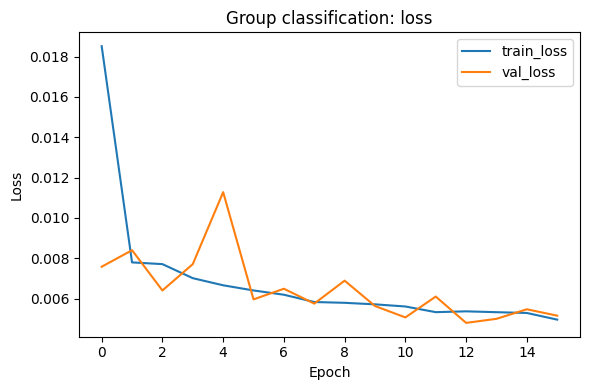

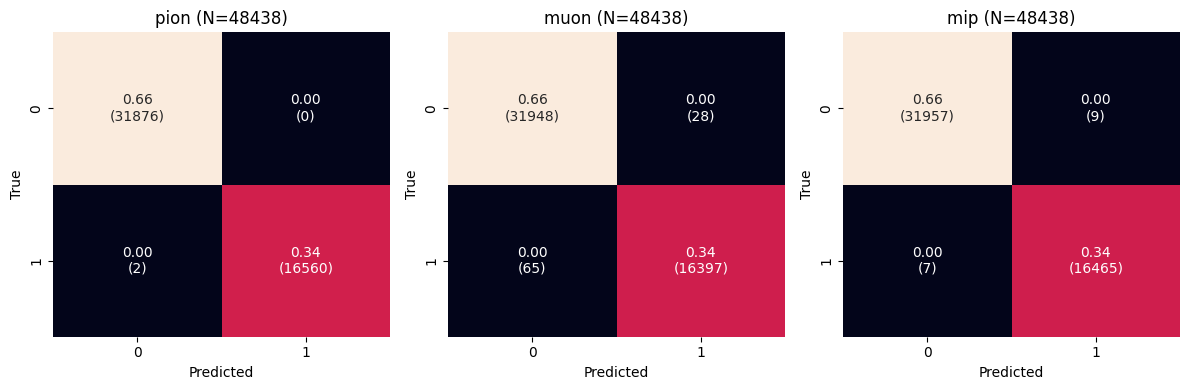

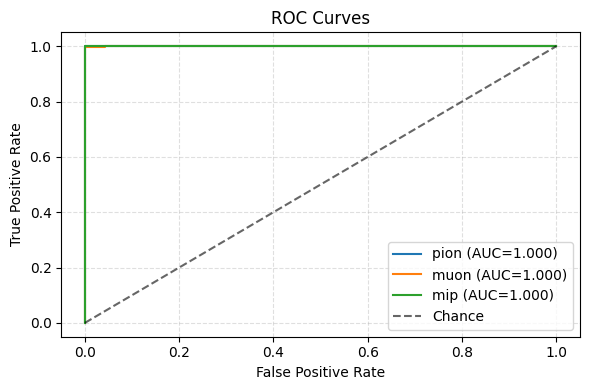

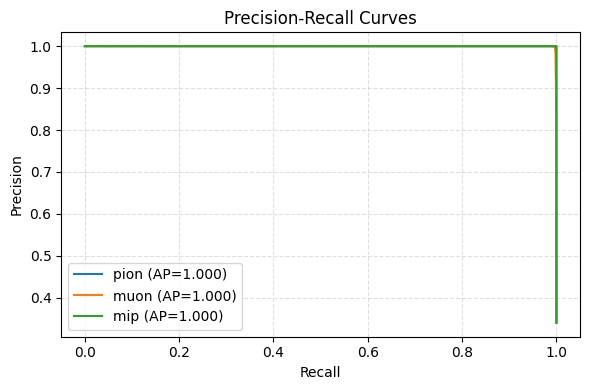

In [5]:
from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)

plot_loss_curves(trained_module, title="Group classification: loss", show=True)
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=class_names,
    threshold=0.5,
    normalize=True,
    show=True,
)
plot_roc_curves(predictions, targets, class_names=class_names, show=True)
plot_precision_recall_curves(predictions, targets, class_names=class_names, show=True)


## Save the Trained Model

Save the trained model and metadata for later use.


In [6]:
from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now

# Build metadata and save model + metadata together
save_ts = timestamp_now()

meta = TrainingMetadata(
    model_type="GroupClassifier",
    timestamp=save_ts,
    run_name=run.name if 'run' in locals() else None,
    best_hyperparameters=best_params,
    best_score=best_params.get('best_score') if isinstance(best_params, dict) else None,
    n_trials=best_params.get('n_trials') if isinstance(best_params, dict) else None,
    training_config=getattr(trained_module, 'training_config', {}),
    epochs_run=getattr(trained_module, 'final_epochs_run', None),
    dataset_info={
        'train_size': len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        'val_size': len(datamodule.val_dataset) if datamodule.val_dataset else 0,
        'num_classes': NUM_GROUP_CLASSES,
        'class_names': class_names,
    },
    model_architecture={
        'num_classes': NUM_GROUP_CLASSES,
        'hidden': best_params.get('hidden') if isinstance(best_params, dict) else None,
        'num_blocks': best_params.get('num_blocks') if isinstance(best_params, dict) else None,
        'dropout': best_params.get('dropout') if isinstance(best_params, dict) else None,
    },
    # Store link to Optuna DB instead of full history
    optuna_storage=optuna_storage,
    optuna_study_name=optuna_manager.study_name,
)

paths = save_model_and_metadata(
    model=trained_module.model,
    metadata=meta,
    state_dict_only=True,
)

print("Saved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")


Saved artifacts:
  dir: /home/jack/python_projects/pioneerML/trained_models/groupclassifier
  state_dict: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20251206_111624_group_classification_optuna_pipeline-2025_12_06-01_40_30_136745_state_dict.pt
  metadata: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20251206_111624_group_classification_optuna_pipeline-2025_12_06-01_40_30_136745_metadata.json
  full_checkpoint: /home/jack/python_projects/pioneerML/trained_models/groupclassifier/groupclassifier_20251206_111624_group_classification_optuna_pipeline-2025_12_06-01_40_30_136745_checkpoint.pt
